# Prepare Data

## Imports and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_code import *
from sklearn.preprocessing import StandardScaler
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load dataset csv
The dataset here basically has the filenames of each recording, and the tf.Dataset object will load the recording itself during the training

In [2]:
full_df = pd.read_csv("full_dataset.csv")
full_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A4924.mat,0,0,0,0,CP
1,data/cpsc/A2054.mat,0,0,0,0,CP
2,data/cpsc/A5391.mat,0,0,0,0,CP
3,data/cpsc/A3580.mat,0,0,0,0,CP
4,data/cpsc/A4948.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS32861.mat,0,0,0,0,NI
85739,data/ningbo/JS41305.mat,0,0,0,0,NI
85740,data/ningbo/JS25189.mat,0,0,0,0,NI
85741,data/ningbo/JS42616.mat,0,0,0,0,NI


In [11]:
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

In [12]:
# Ensure that the % of Afl is the same as the 20% train test split
print("% of Afl in test: {}".format(val_df['Afl'].sum()/full_df['Afl'].sum()))

% of Afl in test: 0.1957812302639889


## Visualize Data Augmentations
We increase the dataset with 3 augmentations:
1. Adding low freq sine wave as baseline wander
2. Adding 50Hz power line noise
3. Adding random gaussian noise

This is to make the model more robust to noise that might be present in real ECG data

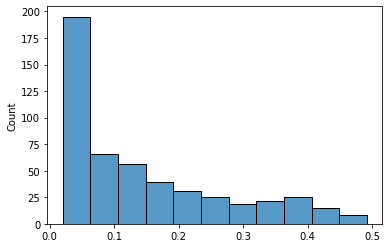

In [13]:
# Use loguniform so as to concentrate the randomness in the lower spectrum

from scipy.stats import loguniform

arr = []
for i in range(500):
    arr.append(loguniform.rvs(0.02, 0.5, size=None))
    
sns.histplot(data=arr)
plt.show()

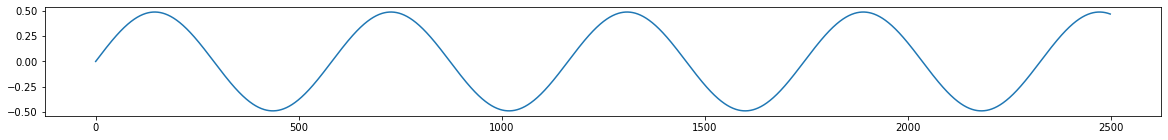

In [14]:
# Baseline Wander

def get_bw(qrs_amp):
    amp = np.random.rand() * 0.15 * qrs_amp      # Amplitude
    f = loguniform.rvs(0.02, 0.5, size=None)     # Frequency
    fs = 250                                     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)

y = get_bw(6)

plt.figure(figsize=(20,2))
plt.plot(list(range(len(y))), y)

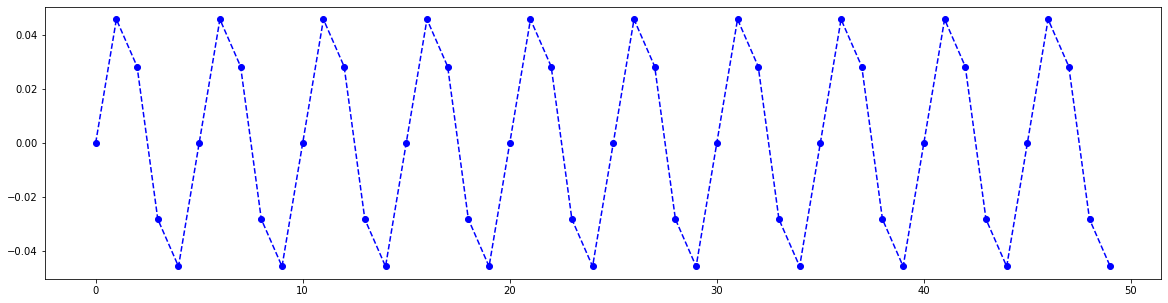

In [15]:
# Power Line

def get_pli(qrs_amp):
    amp = qrs_amp * 0.025 * np.random.rand()    # Amplitude
    f = 50     # Frequency
    fs = 250     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)
    
y = get_pli(6.5)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(y[:50]))), y[:50], '--bo')

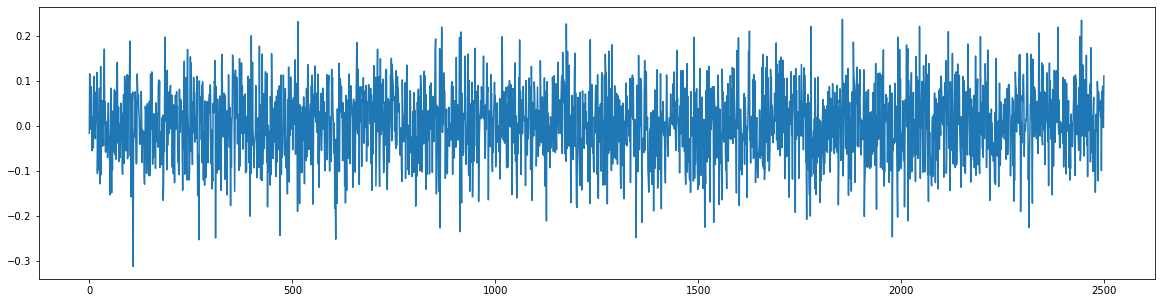

In [16]:
# Gaussian Noise

def get_gauss():
    gauss = np.random.normal(0, 0.08, (2500,))
    
    return gauss

gauss = get_gauss()

plt.figure(figsize=(20,5))
plt.plot(list(range(len(gauss))), gauss)

## Preprocess Signal

In [17]:
scaler = StandardScaler()
# filename = 'data/ptbxl/HR08056.mat' # normal
filename = 'data/chapman/JS06976.mat' # Afl

recording = load_recording(filename)
recording = recording.astype(np.float32).T
recording = recording[0:5000:2] # resample to 250Hz
print(recording.T.shape)
recording = scaler.fit_transform(recording) # Normalize

lead = recording.T

(12, 2500)


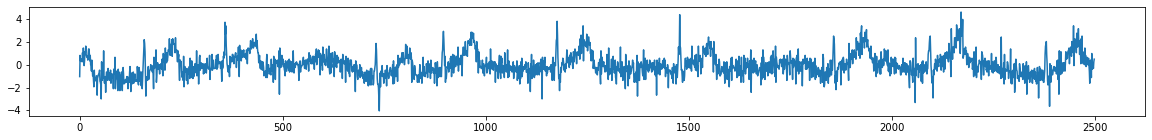

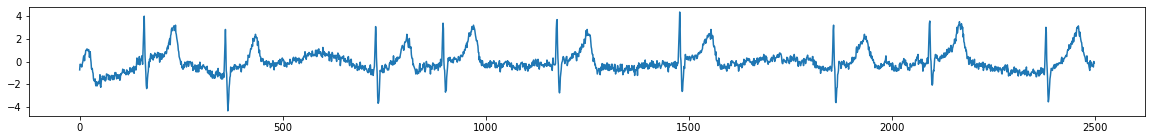

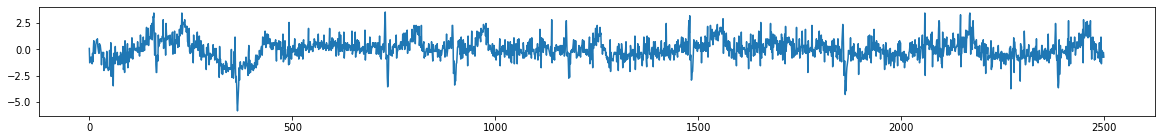

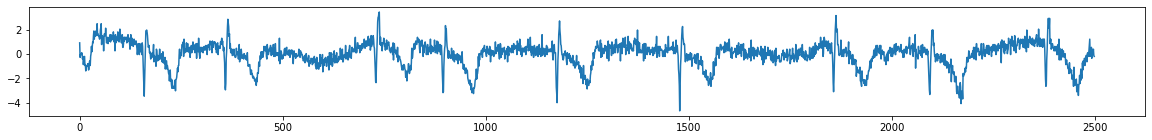

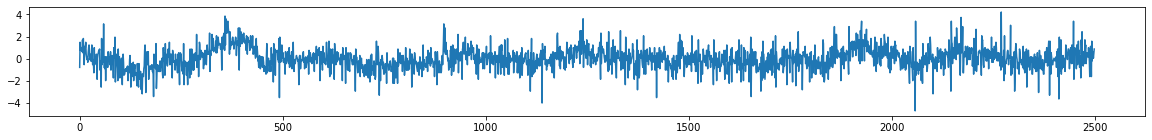

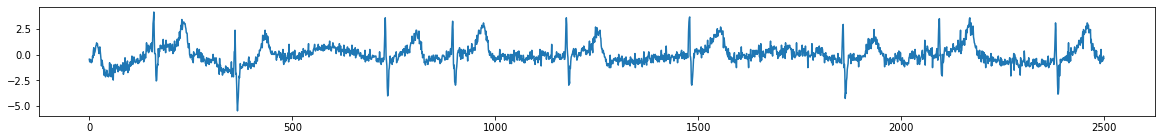

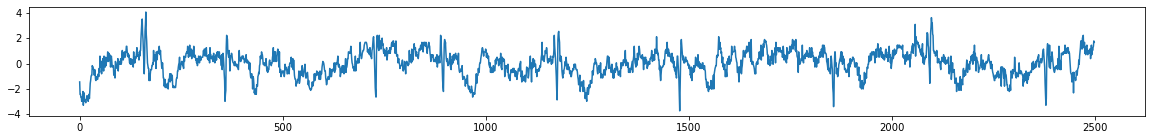

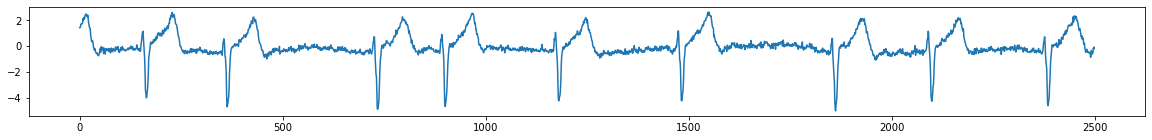

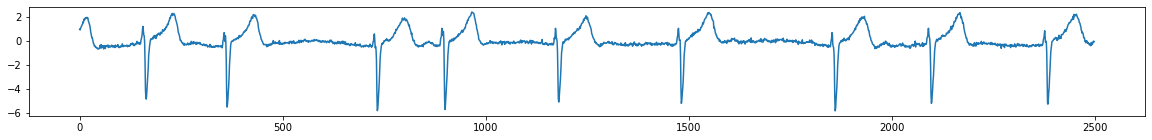

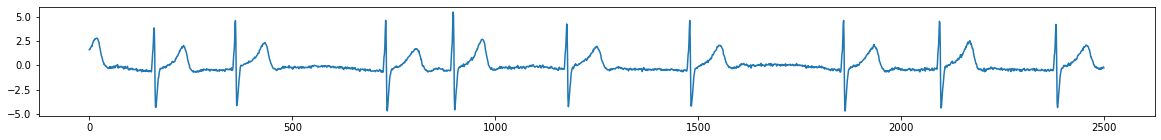

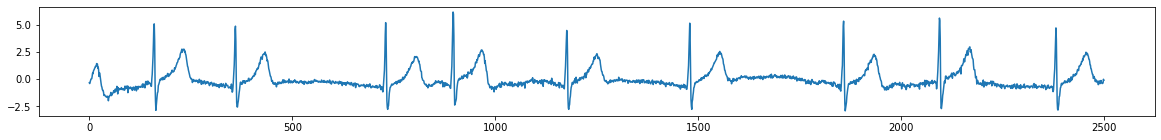

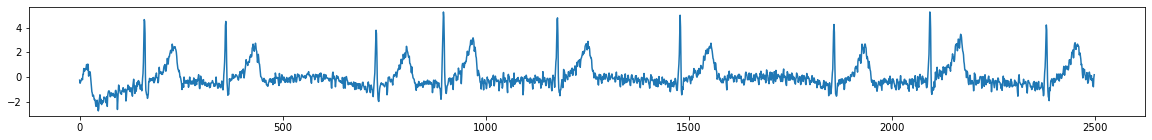

In [18]:
# visualisation of leads without augmentation

for i in range(12):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(lead[i]))), lead[i])

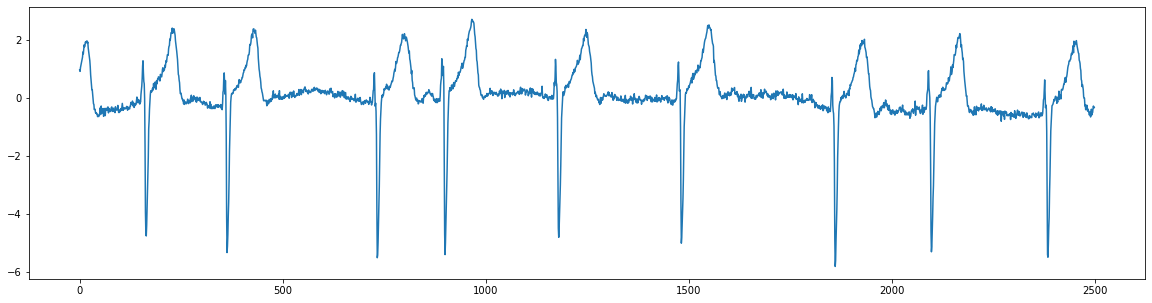

In [19]:
# visualisation of lead with baseline wander
lead_1 = lead[8] + get_bw(6)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(lead_1))), lead_1)

In [20]:
def augment_leads(leads, aug_no):
    new_leads = []
    
    for lead in leads:
        qrs_amp = max(lead.max(), abs(lead.min()))
        
        if aug_no == 2:
            lead = lead + get_bw(qrs_amp)
        elif aug_no == 3:
            lead = lead + get_pli(qrs_amp)
        elif aug_no == 4:
            lead = lead + get_gauss()
        
        new_leads.append(lead)
    
    return np.array(new_leads)

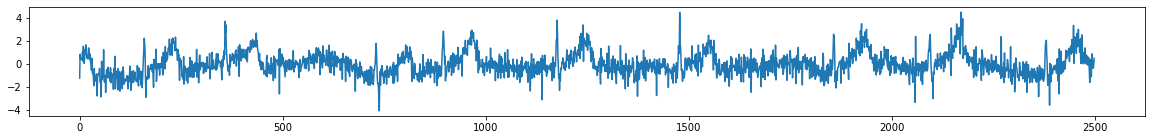

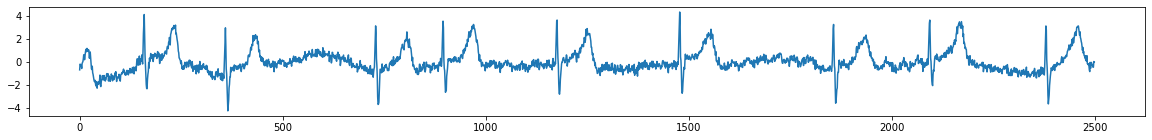

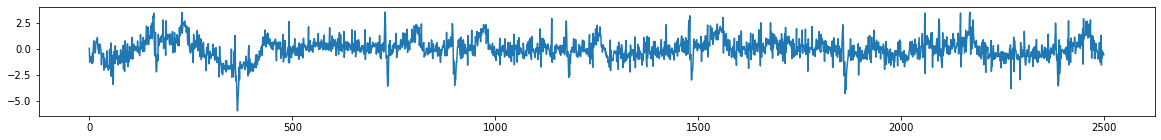

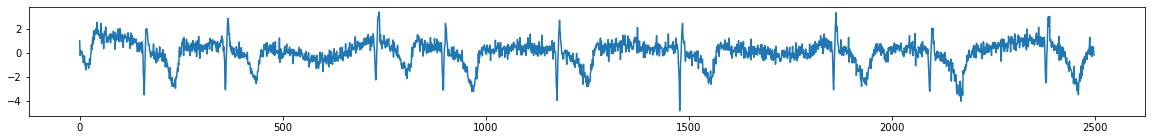

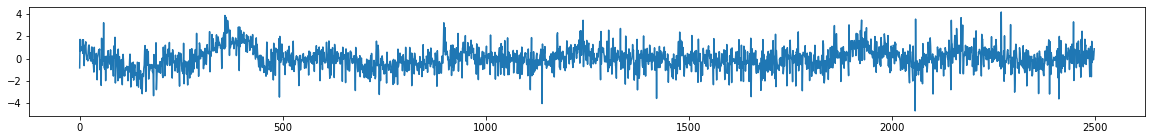

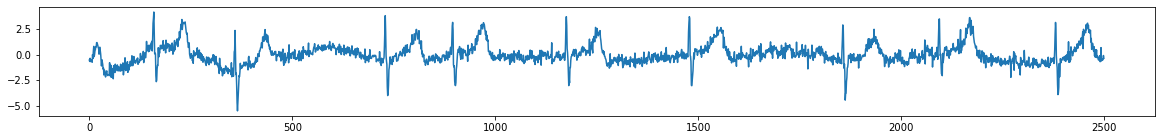

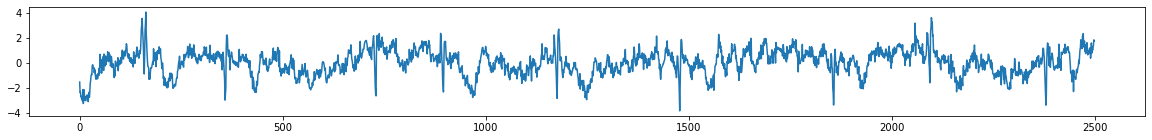

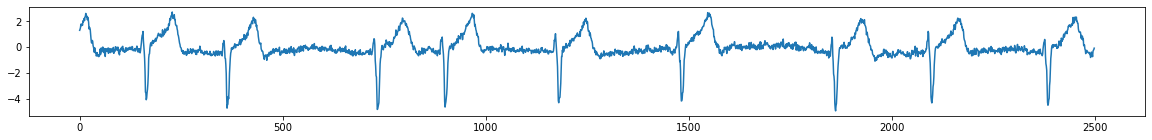

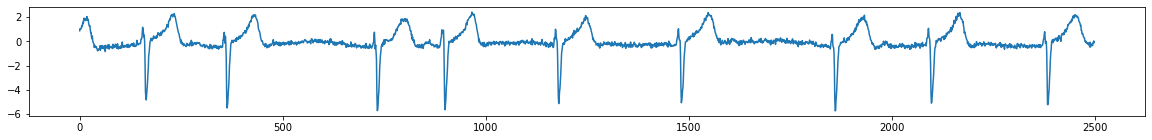

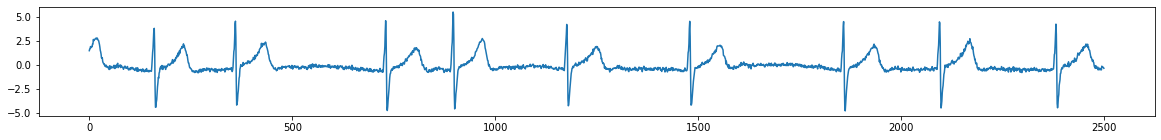

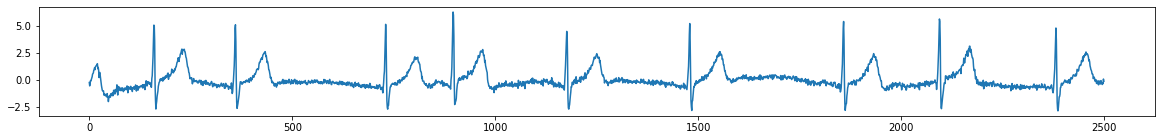

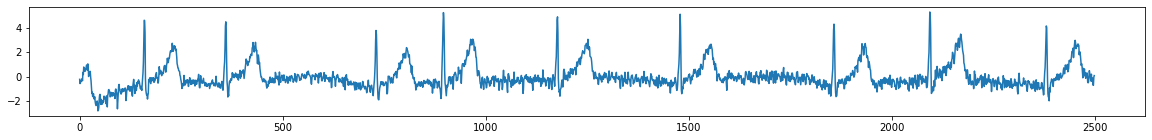

In [22]:
# visualisation of leads with augmentation

lead = augment_leads(lead, 4)

for i in range(12):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(lead[i]))), lead[i])

In [23]:
channels = []
channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
channels.append(lead[1])

channels = np.array(channels)

In [24]:
channels.shape

(4, 2500)

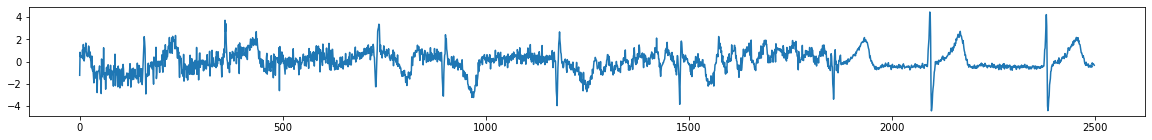

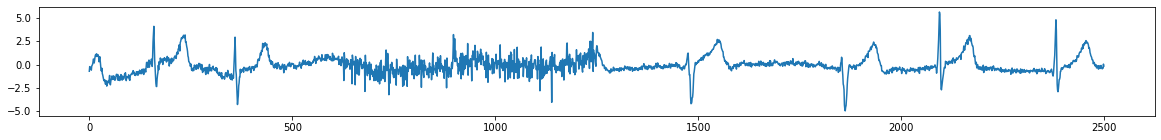

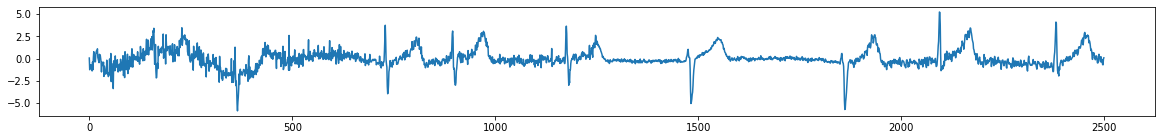

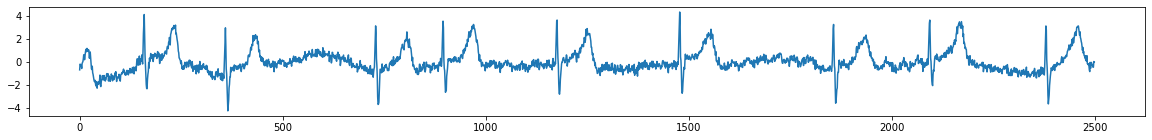

In [25]:
# final input to CNN (ecg with 12 leads but 4 channels)

for i in range(4):
    plt.figure(figsize=(20,2))
    plt.plot(list(range(len(channels[i]))), channels[i])

# Model for Afl

## Prepare Afl Data

In [26]:
afl_train = train_df[['Recording', 'Afl']]
afl_train

,Recording,Afl
38263,data/ptbxl/HR03307.mat,0
81071,data/ningbo/JS34915.mat,0
10602,data/georgia/E02383.mat,0
3428,data/cpsc/A6059.mat,0
60796,data/ningbo/JS38497.mat,0
...,...,...
37194,data/ptbxl/HR09235.mat,0
6265,data/cpsc2/Q2234.mat,0
65133,data/ningbo/JS12730.mat,1
860,data/cpsc/A5399.mat,0


In [27]:
afl_train_F = afl_train[afl_train['Afl'] == 0]
afl_train_F

,Recording,Afl
38263,data/ptbxl/HR03307.mat,0
81071,data/ningbo/JS34915.mat,0
10602,data/georgia/E02383.mat,0
3428,data/cpsc/A6059.mat,0
60796,data/ningbo/JS38497.mat,0
...,...,...
54378,data/ningbo/JS22342.mat,0
37194,data/ptbxl/HR09235.mat,0
6265,data/cpsc2/Q2234.mat,0
860,data/cpsc/A5399.mat,0


In [28]:
afl_train_T = afl_train[afl_train['Afl'] == 1]
afl_train_T

,Recording,Afl
67285,data/ningbo/JS18385.mat,1
73737,data/ningbo/JS16721.mat,1
69627,data/ningbo/JS18372.mat,1
63179,data/ningbo/JS14691.mat,1
64860,data/ningbo/JS13988.mat,1
...,...,...
63954,data/ningbo/JS19511.mat,1
73202,data/ningbo/JS13397.mat,1
51337,data/ningbo/JS13756.mat,1
70510,data/ningbo/JS16175.mat,1


In [29]:
# increase positive afl examples to reduce class imbalance
for i in range(6):
    afl_train_T = pd.concat([afl_train_T, afl_train[afl_train['Afl'] == 1]], ignore_index=True)
afl_train_T

,Recording,Afl
0,data/ningbo/JS18385.mat,1
1,data/ningbo/JS16721.mat,1
2,data/ningbo/JS18372.mat,1
3,data/ningbo/JS14691.mat,1
4,data/ningbo/JS13988.mat,1
...,...,...
44564,data/ningbo/JS19511.mat,1
44565,data/ningbo/JS13397.mat,1
44566,data/ningbo/JS13756.mat,1
44567,data/ningbo/JS16175.mat,1


In [32]:
afl_train = pd.concat([afl_train_T, afl_train_F], ignore_index=True)
afl_train = afl_train.sample(frac=1).reset_index(drop=True)
afl_train

,Recording,Afl
0,data/cpsc/A6487.mat,0
1,data/ptbxl/HR10091.mat,0
2,data/ningbo/JS19553.mat,1
3,data/ningbo/JS20863.mat,0
4,data/ptbxl/HR17106.mat,1
...,...,...
98593,data/ningbo/JS15430.mat,1
98594,data/ningbo/JS19869.mat,1
98595,data/cpsc2/Q0003.mat,0
98596,data/ptbxl/HR19400.mat,0


In [33]:
x_train = np.array(afl_train['Recording'])
x_train

array(['data/cpsc/A6487.mat', 'data/ptbxl/HR10091.mat',
       'data/ningbo/JS19553.mat', ..., 'data/cpsc2/Q0003.mat',
       'data/ptbxl/HR19400.mat', 'data/georgia/E02634.mat'], dtype=object)

In [34]:
y_train = np.array(afl_train[['Afl']])
y_train.shape

(98598, 1)

In [35]:
x_val = np.array(val_df['Recording'])
x_val

array(['data/ptbxl/HR15317.mat', 'data/ningbo/JS45393.mat',
       'data/ningbo/JS33894.mat', ..., 'data/ptbxl/HR21297.mat',
       'data/ningbo/JS29166.mat', 'data/ptbxl/HR13032.mat'], dtype=object)

In [36]:
y_val = np.array(val_df[['Afl']])
y_val.shape

(15100, 1)

## Dataset Prep

Use tf.data.Dateset as a data loader for training

In [37]:
import tensorflow as tf
print(tf.__version__)

2.4.2


In [38]:
scaler = StandardScaler()

In [39]:
def get_ecg(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        # Random number from 1 to 6. 
        # 2, 3, 4 will have augmentations, 1, 5, 6, will be original
        lead = augment_leads(lead, np.random.randint(1, 7))
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.astype(np.float32).T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [40]:
def get_val(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_ecg)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(64, drop_remainder=True)

In [42]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(64, drop_remainder=True)

In [43]:
train_dataset, val_dataset

(<BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>)

## Model Building and Training

In [51]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, AveragePooling1D
from tensorflow.keras.layers import ReLU, Add, MaxPool1D, GlobalAvgPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [52]:
def Conv_BatchNorm(x, filters, kernel_size, strides):
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.03))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return x

In [53]:
def resnet_block(orig_x, num_filters, kernel_size, strides):
    x1 = Conv_BatchNorm(orig_x, filters=num_filters, kernel_size=kernel_size, strides=strides)
    x1 = Conv_BatchNorm(x1, filters=num_filters, kernel_size=kernel_size, strides=1)
    
    x2 = AveragePooling1D(pool_size=2, strides=strides, padding='same')(orig_x)
    x2 = Conv1D(filters=num_filters, kernel_size=1, strides=1, padding='same')(x2)
 
    x = Add()([x1, x2])
    return x

In [55]:
Inp = Input(shape=(2500, 4),name="Inp")
 
x = Conv_BatchNorm(Inp, filters=64, kernel_size=9, strides=2)  
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)

x = resnet_block(x, num_filters=64, kernel_size=3, strides=2)
x = resnet_block(x, num_filters=128, kernel_size=3, strides=2)
x = resnet_block(x, num_filters=256, kernel_size=3, strides=2)
 
x = GlobalAvgPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
 
model = Model(Inp, output, name='simple-res')

In [56]:
model.summary()

Model: "simple-res"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp (InputLayer)                [(None, 2500, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1250, 64)     2368        Inp[0][0]                        
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1250, 64)     256         conv1d_10[0][0]                  
__________________________________________________________________________________________________
re_lu_7 (ReLU)                  (None, 1250, 64)     0           batch_normalization_7[0][0]      
_________________________________________________________________________________________

In [58]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1) # label smoothing to prevent large weights

model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

In [59]:
filepath="afl_checkpoints/weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [62]:
model.fit(train_dataset,
          steps_per_epoch = int(98598/64),
          epochs=20,
          validation_data = val_dataset,
          validation_steps = int(15100/64),
          callbacks=[checkpoint_cb]
          )

Epoch 1/20
1540/1540 [==============================] - 2783s 2s/step - loss: 0.4807 - accuracy: 0.9357 - val_loss: 0.3380 - val_accuracy: 0.9310

Epoch 00001: saving model to afl_checkpoints/weights-01-0.34.hdf5
Epoch 2/20
1540/1540 [==============================] - 2440s 2s/step - loss: 0.3107 - accuracy: 0.9534 - val_loss: 0.2834 - val_accuracy: 0.9592

Epoch 00002: saving model to afl_checkpoints/weights-02-0.28.hdf5
Epoch 3/20
1540/1540 [==============================] - 2436s 2s/step - loss: 0.3007 - accuracy: 0.9589 - val_loss: 0.2941 - val_accuracy: 0.9574

Epoch 00003: saving model to afl_checkpoints/weights-03-0.29.hdf5
Epoch 4/20
1540/1540 [==============================] - 2434s 2s/step - loss: 0.2923 - accuracy: 0.9620 - val_loss: 0.2763 - val_accuracy: 0.9623

Epoch 00004: saving model to afl_checkpoints/weights-04-0.28.hdf5
Epoch 5/20
1540/1540 [==============================] - 2438s 2s/step - loss: 0.2862 - accuracy: 0.9643 - val_loss: 0.2770 - val_accuracy: 0.9634

E

In [214]:
model.load_weights("afl_checkpoints/weights-18-0.25.hdf5")
model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

## Results

Precision = Out of all cases that are PREDICTED as positive, how many of them are ACTUALLY positive

Recall = Out of all cases that are ACTUALLY positive, how many of them are PREDICTED as positive

True Positive Rate = if a patient actually has Afl, how many percent of the time will the algorithm identify that he has Afl

False Positive Rate = if a patient actually does NOT have Afl, how many percent of the time will the algorithm say that he has Afl

### Train Results

In [215]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

In [217]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_val)
train_dataset = train_dataset.batch(64, drop_remainder=False)

In [218]:
y_pred = model.predict(train_dataset)
y_pred

array([[0.29667455],
       [0.05750089],
       [0.9165113 ],
       ...,
       [0.06035444],
       [0.02037218],
       [0.0377311 ]], dtype=float32)

In [220]:
afl_true = y_train.T[0]
afl_pred = y_pred.T[0]

afl_pred = np.around(afl_pred).astype(np.int)

In [221]:
cf_m = confusion_matrix(afl_true, afl_pred)
cf_m

array([[53594,   435],
       [  497, 44072]])

True Postive Rate: 0.9888487513742736
False Postive Rate: 0.00805123174591423


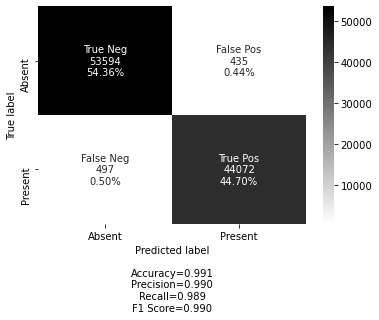

In [223]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

### Test Results

In [224]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.batch(64, drop_remainder=False)

In [225]:
y_pred = model.predict(val_dataset)
y_pred

array([[0.04904023],
       [0.34497005],
       [0.03052856],
       ...,
       [0.03418262],
       [0.06036412],
       [0.02903764]], dtype=float32)

In [229]:
afl_true = y_val.T[0]
afl_pred = y_pred.T[0]

afl_pred = np.around(afl_pred).astype(np.int)

In [230]:
cf_m = confusion_matrix(afl_true, afl_pred)
cf_m

array([[13322,   228],
       [  142,  1408]])

True Postive Rate: 0.9083870967741936
False Postive Rate: 0.016826568265682657


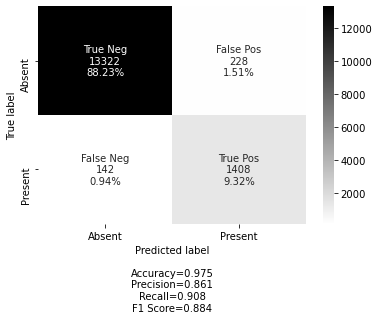

In [231]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

## Save Model

In [232]:
model.save('afl_model.h5')
loaded_model = tf.keras.models.load_model('afl_model.h5')